<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import math
import numpy as np
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
n_epochs = 200
batch_size = 64
lr = 0.00005
latent_dim  = 100
b1 = 0.5
b2 = 0.999
img_size = 28
channels = 1
n_critic = 5           #number of training steps for discriminator per iter
clip_value = 0.01      #lower and upper clip value for disc. weights
display_step = 5000
image_shape = (channels,img_size,img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        def block(in_feats,out_feats,normalize = True):
            layers = [nn.Linear(in_feats,out_feats)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feats,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace = True))
            return layers
        self.model = nn.Sequential(
            *block(latent_dim,128,normalize = False),
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,int(np.prod(image_shape))),
            nn.Tanh()
        )
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0),*image_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(image_shape)),512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(256,1)
        )
    def forward(self,img):
        img_flat = img.view(img.size(0),-1)
        validity = self.model(img_flat)
        return validity

In [6]:
# Loss weight for gradient penalty
lambda_gp = 10
generator = Generator().to(device)
discriminator = Discriminator().to(device)


dataloader

In [7]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download = True,
        train  = True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)
optimizer_G = torch.optim.Adam(generator.parameters(),lr = lr,betas= (b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters() , betas = (b1,b2))

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()



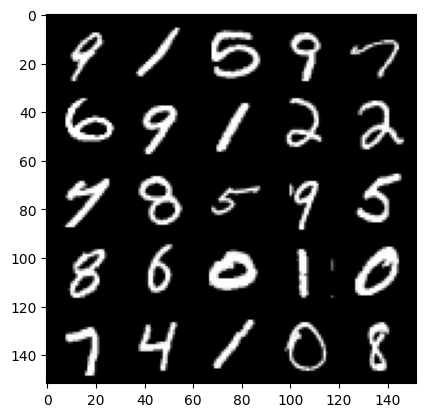

In [9]:
images,labels = next(iter(dataloader))
show_tensor_images(images)

In [10]:
def compute_gradient_penalty(D,real_samples,fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    device = real_samples.device
    batch_size = real_samples.size(0)
     # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(batch_size,1,1,1,device = device)

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    # Compute D(interpolates) and its gradients w.r.t. interpolates
    d_interpolates = D(interpolates)

    gradients = torch.autograd.grad(
        outputs = d_interpolates,
        inputs = interpolates,
        grad_outputs = torch.ones_like(d_interpolates,device = device),
        create_graph = True,
        retain_graph = True,
        only_inputs= True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [11]:
from tqdm import tqdm

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(imgs,_) in enumerate(tqdm(dataloader)):
        real_imgs =  imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.normal(0,1,(real_imgs.size(0),latent_dim)).to(device)
        # Generate a batch of images
        fake_imgs = generator(z)

        #real images
        real_validity = discriminator(real_imgs)
        #fake images
        fake_validity = discriminator(fake_imgs)

        gradient_penalty = compute_gradient_penalty(discriminator,real_imgs.data,fake_imgs.data)

        #adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += d_loss.item() / display_step


        optimizer_G.zero_grad()
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------

            #generate a batch of images
            fake_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()


            # Keep track of the average generator loss
            mean_generator_loss += g_loss.item() / display_step

            ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            print('----------------fake images-------------')
            show_tensor_images(fake_imgs)
            print('----------------real images-------------')
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1